In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import shape
from neurodsp.shape.cyclefeatures import define_true_oscillating_periods
from scipy import stats
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# A-E. Examples signals considered as potential oscillations

In [2]:
Fs = 1000
period_ms = 100
rdsym = .4

# Generate good phase time series
rise_ms = np.round(period_ms * rdsym)
decay_ms = period_ms - rise_ms
pha_1cycle = np.hstack([np.linspace(0, np.pi, decay_ms+1), np.linspace(-np.pi, 0, rise_ms+1)[1:-1]])
pha_good = np.tile(pha_1cycle, 3)

# Generate good signal
x_good = np.cos(pha_good)

# Generate signal with bad amplitude dynamics
x_bad1 = np.copy(x_good)
x_bad1[160:200] = x_bad1[160:200]/2 - .5
x_bad1[200:] = x_bad1[200:]/2 - .5

# Generate bad phase time series
period2 = 50
rise_ms = np.round(period2 * rdsym)
decay_ms = period2 - rise_ms
pha_1cycle_bad = np.hstack([np.linspace(0, np.pi, decay_ms+1), np.linspace(-np.pi, 0, rise_ms+1)[1:-1]])
pha_bad = np.hstack([pha_1cycle_bad, pha_1cycle_bad, pha_1cycle, pha_1cycle_bad, pha_1cycle_bad])
x_bad2 = np.cos(pha_bad)

# Generate signal that has nonmonotonic flanks
pha_bad2 = np.copy(pha_good)
from scipy.stats import norm
gauss_x = np.linspace(norm.ppf(.01), norm.ppf(.99), 45)
x_bad3 = np.cos(pha_bad2)
x_bad3[115:160] = x_bad3[115:160] + norm.pdf(gauss_x)*3

# Generate noise signal that is no oscillation
np.random.seed(0)
x_bad4 = neurodsp.sim_filtered_brown_noise(10, 1000, (2, None), 1001)
x_bad4 = x_bad4[1000:1300]
x_bad4 = (x_bad4 - np.min(x_bad4)) / (np.max(x_bad4) - np.min(x_bad4))
x_bad4 = x_bad4*2 - 1

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


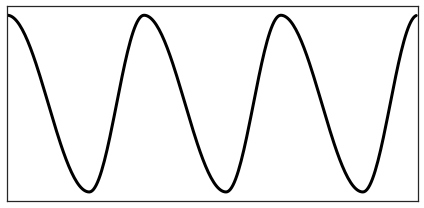

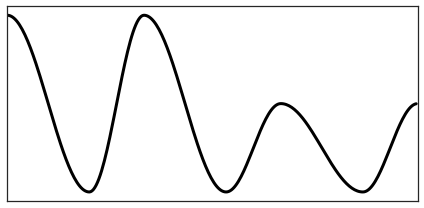

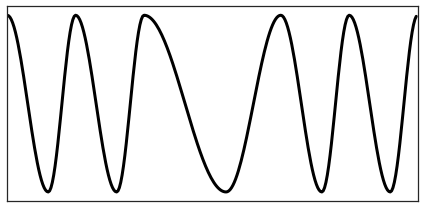

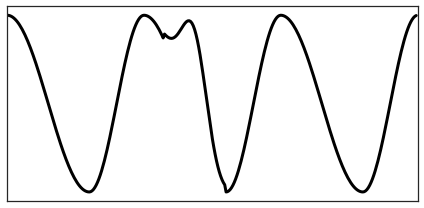

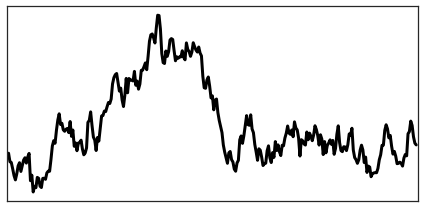

In [3]:
plt.figure(figsize=(6,3))
plt.plot(x_good, color='k', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim((-1.1,1.1))
plt.xlim((0, len(x_good)))
plt.tight_layout()
plt.savefig('figs/3A_good_oscillator.png')

plt.figure(figsize=(6,3))
plt.plot(x_bad1, color='k', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim((-1.1,1.1))
plt.xlim((0, len(x_good)))
plt.tight_layout()
plt.savefig('figs/3B_bad_amp_oscillator.png')

plt.figure(figsize=(6,3))
plt.plot(x_bad2, color='k', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim((-1.1,1.1))
plt.xlim((0, len(x_good)))
plt.tight_layout()
plt.savefig('figs/3C_bad_period_oscillator.png')

plt.figure(figsize=(6,3))
plt.plot(x_bad3, color='k', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim((-1.1,1.1))
plt.xlim((0, len(x_good)))
plt.tight_layout()
plt.savefig('figs/3D_nonmonotonic_oscillator.png')

plt.figure(figsize=(6,3))
plt.plot(x_bad4, color='k', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.ylim((-1.1,1.1))
plt.xlim((0, len(x_good)))
plt.tight_layout()
plt.savefig('figs/3E_noise_nonoscillator.png')

# F. Minimum number of cycles

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


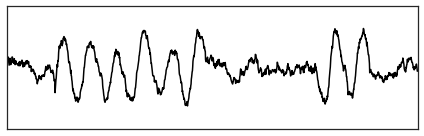

In [8]:
# Simulate two noisy oscillators with different rise-decay symmetries
Fs = 1000
N_cycles = 100
N_cycles_post = 15
period_ms = 100
f_hipass = 2
power_ratio = .1 # Higher power ratio is more noise
rdsym = .4
np.random.seed(0)

# Make sawtooth
rise_ms = np.round(period_ms * rdsym)
decay_ms = period_ms - rise_ms
pha_one_cycle = np.hstack([np.linspace(0, np.pi, decay_ms+1), np.linspace(-np.pi, 0, rise_ms+1)[1:-1]])
phase_t = np.tile(pha_one_cycle, N_cycles)
x_sawtooth = np.cos(phase_t)
x_sawtooth = x_sawtooth[:N_cycles_post*period_ms]
t = np.arange(0, len(x_sawtooth)/Fs, 1/Fs)

# Simulate brown noise
x_brown = neurodsp.sim.sim_filtered_brown_noise(len(t) / Fs, Fs, (f_hipass, None), int(Fs/2 + 1))

# Normalize brown noise power
sawtooth_power = np.mean(x_sawtooth**2)
brown_power = np.mean(x_brown**2)
x_brown = np.sqrt(x_brown**2 * power_ratio * sawtooth_power / brown_power) * np.sign(x_brown)

# Combine signals
x = np.copy(x_brown)
x[1125:1325] += x_sawtooth[1125:1325]
x[175:725] += x_sawtooth[175:725]

# Plot a short and long burst
plt.figure(figsize=(6,2))
plt.plot(x, 'k')
plt.xticks([])
plt.yticks([])
plt.xlim((0, len(x)))
plt.ylim((-2,2))
plt.tight_layout()
plt.savefig('figs/3F_burst_length.png')

# G. Effect of oscillator parameters on number of oscillating cycles declared

In [5]:
# Load LFP
lfp_raw = np.load('data/ca1.npy')
lfp_raw = lfp_raw[:125200]
Fs_lfp = 1252
f_theta = (4, 10)

# Apply broad bandpass filter
f_bandpass = (1, 25)
filter_seconds = (2, .5)
lfp = neurodsp.filter(lfp_raw, Fs_lfp, 'highpass', f_hi=f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
lfp = neurodsp.filter(lfp, Fs_lfp, 'lowpass', f_lo=f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

# Compute cycle by cycle features
df = shape.features_by_cycle(lfp, Fs, f_theta, center_extrema='T')

# Vary consistency and monotonicity thresholds
amp_consist_vals = np.arange(0, 1, .05)
period_consist_vals = np.arange(0, 1, .05)
mono_th = .8
osc_dict = defaultdict(list)
for per_th in period_consist_vals:
    for amp_th in amp_consist_vals:

        # Compute if each cycle is oscillating
        osc_kws = {'amplitude_consistency_threshold': amp_th,
                   'period_consistency_threshold': per_th,
                   'monotonicity_threshold': mono_th}
        df = define_true_oscillating_periods(df, lfp, **osc_kws)

        # Save results
        osc_dict['frac_cycles'].append(df['is_cycle'].mean())
        osc_dict['amp_consist_thresh'].append(amp_th)
        osc_dict['period_consist_thresh'].append(per_th)
df_osc = pd.DataFrame(osc_dict)

/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


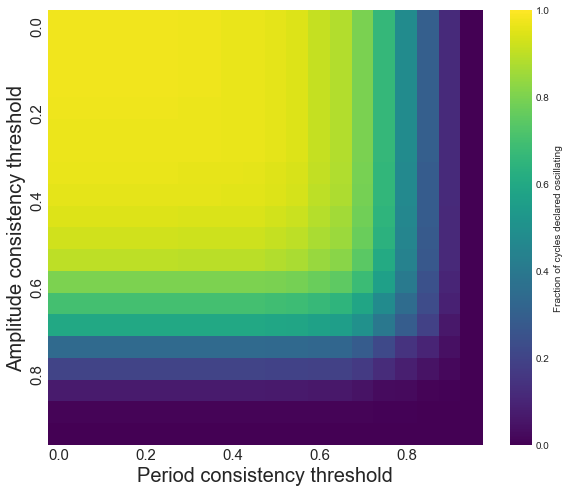

In [6]:
df_plt = df_osc.pivot('amp_consist_thresh', 'period_consist_thresh', 'frac_cycles')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_plt, vmin=0, vmax=1, cmap=cm.viridis, xticklabels=4, yticklabels=4, square=True,
                 cbar_kws={'label': 'Fraction of cycles declared oscillating', 'ticks':np.arange(0,1.2,.2)})
plt.xlabel('Period consistency threshold', size=20)
plt.ylabel('Amplitude consistency threshold', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('figs/3G_oscillating_params_vs_burst_fraction.png')